<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
data = pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [2]:
data['datetime'] = pd.to_datetime(
    data['datetime'], format='%Y-%m-%dT%H:%M:%S'
) 
data.sort_index(inplace=True)
data = data.set_index('datetime')

In [3]:
data = data.resample('1H').sum()

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
print(data.isna().sum()[0], data.duplicated().sum())

0 4165


пропусков нет, очень много дублирующихся строк, но удалив их мы удалим практически весь датасет.

## Анализ

In [6]:
data.resample('1M').sum().head()

,num_orders
datetime,
2018-03-31,42768
2018-04-30,45939
2018-05-31,54820
2018-06-30,59906
2018-07-31,74405


У нас есть данные только за 3-7 месяцы 2018 года. 

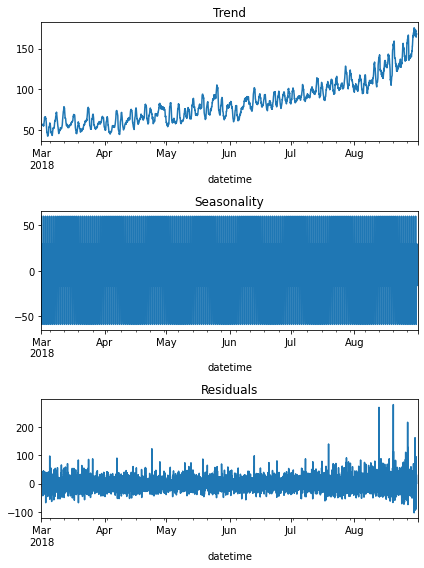

In [7]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Есть линейный восходящий тренд, сезонность не наблюдается.

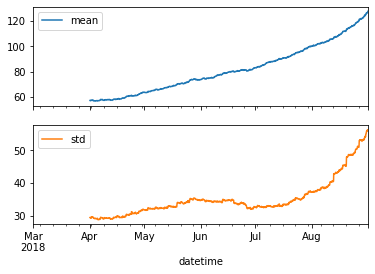

In [8]:
data_hist = data.copy()
data_hist['mean'] = data_hist['num_orders'].rolling(750).mean()
data_hist['std'] = data_hist['num_orders'].rolling(750).std()
data_hist.loc[:,['mean','std']].plot(subplots = True);

На данном графике я преобразовал данные "скользящим средним", чтобы лучше было видно линейный тренд - среднее значение заказов повышается с каждым месяцем.

Наши ряды нестанционарны, так как меняется среднее значение.

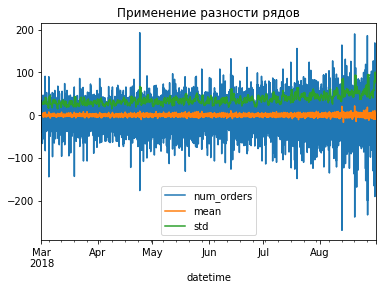

In [9]:
data_raz = data - data.shift()
data_raz['mean'] = data_raz['num_orders'].rolling(20).mean()
data_raz['std'] = data_raz['num_orders'].rolling(20).std()
data_raz.plot();
plt.title('Применение разности рядов');

С помощью разностей временных рядов я попробовал преобразовать данные, но даже при большом значении "скользящего среднего" стандартное отклонение растет.

## Обучение

Для начала хочу создать синтетический признак - день недели.

In [10]:
def make_features(df, max_lag, rolling_size):
    df['dayofweek'] = df.index.dayofweek
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['rolling_mean'].fillna(df['rolling_mean'].median())

In [11]:
make_features(data, 180, 40)
data = data.fillna(data['num_orders'].median())

In [12]:
train, test = train_test_split(data, test_size = 0.1, shuffle = False)
train, valid = train_test_split(train, test_size = 0.1, shuffle = False)
y_train = train['num_orders']
y_test = test['num_orders']
y_valid = valid['num_orders']
x_train = train.drop('num_orders', axis = 1)
x_test = test.drop('num_orders', axis = 1)
x_valid = valid.drop('num_orders', axis = 1)
print(train.shape, test.shape, valid.shape)

(3576, 185) (442, 185) (398, 185)


In [13]:
best_rmse = 1000
for depth in [1,3,5,7,9]:
    for est in [100,200,300,400]:
        model = RandomForestRegressor(max_depth = depth, n_estimators = est)
        model.fit(x_train, y_train)
        predict = model.predict(x_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, predict))
        if rmse < best_rmse:
            best_depth = depth
            best_est = est
            best_rmse = rmse
            best_rf_model = model
print('depth:', best_depth, 'est:', best_est, 'rmse:',best_rmse)

depth: 9 est: 200 rmse: 29.831107962457935


In [14]:
best_rmse = 1000
for inter in [True, False]:
    for job in [-1, 1]:
        model_regression = LinearRegression(fit_intercept = inter,n_jobs = job)
        model.fit(x_train, y_train)
        predict = model.predict(x_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, predict))
        if rmse < best_rmse:
            best_inter = inter
            best_job = job
            best_rmse = rmse
            best_lr_model = model
print('inter:', inter, 'job:', job, 'rmse:',best_rmse)

inter: False job: 1 rmse: 29.928188071289373


In [15]:
parametrs = {'iterations': range(10, 40, 5),
             'learning_rate': np.arange(0.01, 0.7, 0.05),
             }
model_cat = CatBoostRegressor()
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_cat,
                       param_grid=parametrs,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1,
                       cv=tscv,
                       verbose=10)
grid.fit(x_train, y_train)
grid.best_score_

Fitting 8 folds for each of 84 candidates, totalling 672 fits
[CV 1/8; 1/84] START iterations=10, learning_rate=0.01..........................
0:	learn: 29.4301577	total: 77.9ms	remaining: 701ms
1:	learn: 29.3457700	total: 96ms	remaining: 384ms
2:	learn: 29.2377354	total: 114ms	remaining: 267ms
3:	learn: 29.1253232	total: 143ms	remaining: 214ms
4:	learn: 29.0238265	total: 165ms	remaining: 165ms
5:	learn: 28.9348696	total: 183ms	remaining: 122ms
6:	learn: 28.8398770	total: 202ms	remaining: 86.7ms
7:	learn: 28.7393884	total: 221ms	remaining: 55.2ms
8:	learn: 28.6286830	total: 253ms	remaining: 28.1ms
9:	learn: 28.5230023	total: 272ms	remaining: 0us
[CV 1/8; 1/84] END ........iterations=10, learning_rate=0.01; total time=   0.9s
[CV 2/8; 1/84] START iterations=10, learning_rate=0.01..........................
0:	learn: 29.4323383	total: 44.9ms	remaining: 404ms
1:	learn: 29.3036161	total: 80.7ms	remaining: 323ms
2:	learn: 29.1987755	total: 104ms	remaining: 242ms
3:	learn: 29.0825252	total: 1

-21.118143398674313

Вывод: лучше всего показала себя модель RFR.

## Тестирование

In [16]:
pred = grid.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE на тестовой выборке:',rmse)

RMSE на тестовой выборке: 47.56311233928569


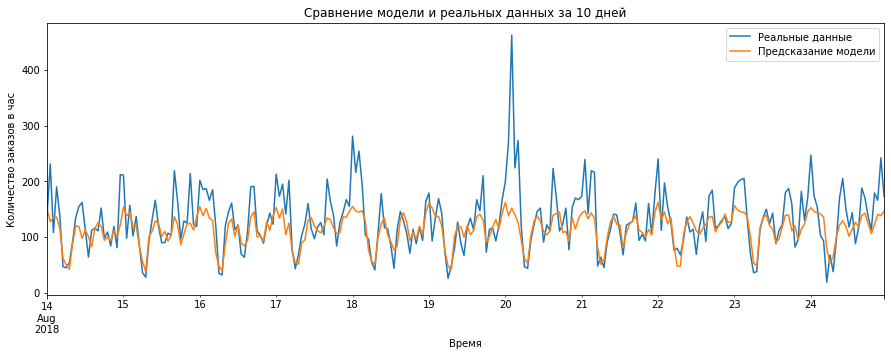

In [17]:
pred = pd.DataFrame(pred, index = y_test.index)
y_test = y_test.sort_index()
pred = pred.sort_index()
plt.figure(figsize=(15, 5))
plt.subplot()
y_test['2018-08-14':'2018-08-24'].plot(ax=plt.gca(), label='Реальные данные')
pred['2018-08-14':'2018-08-24'].plot(ax=plt.gca(), label='Предсказание модели')
plt.legend(['Реальные данные', 'Предсказание модели'])
plt.xlabel('Время')
plt.ylabel('Количество заказов в час')

plt.title('Сравнение модели и реальных данных за 10 дней');

**Вывод:**
В данной работе я:
- Загрузил данные
- Провел ресемплирование
- Проанализировал данные.
- Обучил модели RandomForestRegressor, LinearRegressor и CatBoost с различными гиперпараметрами.
- Проверил данные на тестовой выборке.
- Построил график сравнения предсказаний и реальных значений.

Модель прошла порог в 48 метрики RMSE, получив значение 47. На графике предсказаний видно, что модель хорошо определяет точки минимума, но сильно ошибается в точках максимума.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48